## Sieci głębokie CNN

#### Opracowanie: Stanisław Osowski, Robert Szmurło  
Wersja: 28.03.2021

Sieci głębokie CNN stanowią połączenie nienadzorowanej ekstrakcji cech diagnostycznych obrazu (warstwy ukryte lokalnie połączone) z właściwym klasyfikatorem w końcowej części struktury sieciowej w pełni połączonej. Na wejście sieci podawane są oryginalne obrazy. Sieć CNN automatycznie generuje cechy diagnostyczne, które są procesowane przez w pełni połączone warstwy klasyfikatora właściwego.

W badaniach korzystać będziemy z techniki  „transfer learning”, czyli sieci wstępnie nauczonej na uniwersalnym (bardzo dużym) zbiorze danych, która podlega douczeniu na aktualnie analizowanym zbiorze obrazów. W tym podejściu uczeniu podlega jedynie część sieci w pełni połączona stanowiąca klasyfikator właściwy.

Badania dotyczyć będą zbioru fotografii twarzy. Jeden zbiór stanowią obrazy w skali szarości, drugi – obrazy kolorowe RGB. Maksymalna liczebność pierwszego zbioru to 68 klas, drugiego – 240. Dla polepszenia dokładności stosuje się zespół klasyfikatorów zintegrowanych na zasadzie głosowania większościowego.


Badanie CNN na bazie obrazów w skali szarości

* Zapoznać się z bazą danych obrazów: ALEX_obrazy20
* Dołączyć do sprawozdania po jednym reprezentancie każdej klasy obrazów
* Przeprowadzić badania skuteczności uczenia dla bazy fotografii w skali szarości ograniczonej do 20 klas. Przeprowadzić 4 próby uczenia, notując wyniki dla poszczególnych prób, ich średniej oraz zespołu klasyfikatorów zintegrowanych w trybie głosowania większościowego. Wyniki zanotować w stosownej tabeli.

In [217]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd

plt.rc('font', size=6) 

Pobieramy przkładowe obrazy udostępnione w chmurze plików Wydziału Elekrycznego PW: https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/3Qn5HHRQ38Axk5G

Zbiór obrazów zawiera 400 zdjęć 20 osób przypisanych do odpowiednich klas.

Procedura:
1. Pobieramy archiwum zip pod nazwę: `alexnet_20.zip`.
2. Rozpazkowujemy archiwum do bieżącego folderu.
3. Sprawdzamy czy został utworzony wybrany plik z obrazem.

In [218]:
!wget -O alexnet_20.zip https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/3Qn5HHRQ38Axk5G/download 
!unzip -o -q alexnet_20.zip
with open("./Alex_obrazy20/1/1.jpg") as f:
    print(f"{'-'*70}\nZrobione. Pliki znajdują się w podfolderach w katalogu ./Alex_obrazy20\n{'-'*70}")

--2021-03-28 12:07:04--  https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/3Qn5HHRQ38Axk5G/download
Resolving cloud.ee.pw.edu.pl (cloud.ee.pw.edu.pl)... 194.29.144.210
Connecting to cloud.ee.pw.edu.pl (cloud.ee.pw.edu.pl)|194.29.144.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1176915 (1.1M) [application/zip]
Saving to: ‘alexnet_20.zip’

alexnet_20.zip      100%[===================>]   1.12M   908KB/s    in 1.3s    

2021-03-28 12:07:06 (908 KB/s) - ‘alexnet_20.zip’ saved [1176915/1176915]

----------------------------------------------------------------------
Zrobione. Pliki znajdują się w podfolderach w katalogu ./Alex_obrazy20
----------------------------------------------------------------------


Wyświetlimy listę podfolderów, których nazwy jednocześnie definiują definiują etykiety klas uczących.

In [219]:
!ls -l ./Alex_obrazy20

total 80
drwxr-xr-x 2 root root 4096 Mar 28 12:07 1
drwxr-xr-x 2 root root 4096 Mar 28 12:07 10
drwxr-xr-x 2 root root 4096 Mar 28 12:07 11
drwxr-xr-x 2 root root 4096 Mar 28 12:07 12
drwxr-xr-x 2 root root 4096 Mar 28 12:07 13
drwxr-xr-x 2 root root 4096 Mar 28 12:07 14
drwxr-xr-x 2 root root 4096 Mar 28 12:07 15
drwxr-xr-x 2 root root 4096 Mar 28 12:07 16
drwxr-xr-x 2 root root 4096 Mar 28 12:07 17
drwxr-xr-x 2 root root 4096 Mar 28 12:07 18
drwxr-xr-x 2 root root 4096 Mar 28 12:07 19
drwxr-xr-x 2 root root 4096 Mar 28 12:07 2
drwxr-xr-x 2 root root 4096 Mar 28 12:07 20
drwxr-xr-x 2 root root 4096 Mar 28 12:07 3
drwxr-xr-x 2 root root 4096 Mar 28 12:07 4
drwxr-xr-x 2 root root 4096 Mar 28 12:07 5
drwxr-xr-x 2 root root 4096 Mar 28 12:07 6
drwxr-xr-x 2 root root 4096 Mar 28 12:07 7
drwxr-xr-x 2 root root 4096 Mar 28 12:07 8
drwxr-xr-x 2 root root 4096 Mar 28 12:07 9


Zdefiniujemy funkcję wczytującą obrazy z zadanego folderu.

In [220]:
def read_images(folder="./Alex_obrazy20"):
    from keras.preprocessing.image import load_img
    from keras.preprocessing.image import img_to_array

    images_list=[]
    target_list=[]
    folder="./Alex_obrazy20"
    for sub in next(os.walk(folder))[1]:
        for im in next(os.walk(os.path.join(folder,sub)))[2]:

            # load the image
            img = load_img(os.path.join(folder,sub,im))
            # print("Original:", type(img))

            # convert to numpy array
            img_array = img_to_array(img)
            # print(img_array.shape)
            images_list.append(img_array)
            target_list.append(int(sub))

    images = np.array(images_list)
    target = np.array(target_list)
    return images, target

Wczytujemy obrazy.

In [221]:
images, labels = read_images()
display(images.shape)
display(labels.shape)

(400, 100, 100, 3)

(400,)

Domyślnie, nazwy folderów a zatem wartości klas zaczynają się od liczby `1`. Sieć w dalszej części będzie numerować klasy zaczynając od wartości `0`. Zatem zmniejszamy automatycznie wszystkie klasy na początku.

In [222]:
labels = labels - 1

Korzystamy z funkcji `interact` aby interaktywnie przeglądać wczytane 400 zdjęć.

In [223]:
from ipywidgets import interact

In [224]:
@interact(idx=(0,399,1))
def show_image(idx):
    img = images[idx,:,:,:]
    #display(img)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Klasa: {labels[idx]}")

#show_image(100)

interactive(children=(IntSlider(value=199, description='idx', max=399), Output()), _dom_classes=('widget-inter…

Dzielimi wczytany zbiór danych na trzy części: dane uczące, walidujące oraz testowe. Skorzystamy z funkcji `scikitlearn`, aby wybór danych był automatycznie losowy. Dane będą odpowiednio wymieszane z wszystkich klas. 

In [225]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2)

print(f"Rozmiar danych uczących:      {train_images.shape}")
print(f"Rozmiar danych walidujących:  {validation_images.shape}")
print(f"Rozmiar danych testujących:   {test_images.shape}")
print(f"Rozmiar etykiet uczących:     {train_labels.shape}")
print(f"Rozmiar etykiet walidujących: {validation_labels.shape}")
print(f"Rozmiar etykiet testujących:  {test_labels.shape}")


Rozmiar danych uczących:      (256, 100, 100, 3)
Rozmiar danych walidujących:  (64, 100, 100, 3)
Rozmiar danych testujących:   (80, 100, 100, 3)
Rozmiar etykiet uczących:     (256,)
Rozmiar etykiet walidujących: (64,)
Rozmiar etykiet testujących:  (80,)


Tworzymy obiekty do których będzie owoływać się Keras w celu pobierania porcji danych. Obiekty są dostosowane do pobierania dancyh w porcjach (batch), udostęþniania danych do procesora GPU, rozpraszania danych między wieloma węzłami obliczenowymi.

In [226]:
train_ds = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) )
test_ds =  tf.data.Dataset.from_tensor_slices( (test_images, test_labels) )
validation_ds =  tf.data.Dataset.from_tensor_slices( (validation_images, validation_labels) )

Zapamiętujmy rozmiary danych w zmiennych pomocnicznych.

In [227]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

print(f"Training data size: {train_ds_size}")
print(f"Test data size: {test_ds_size}")
print(f"Validation data size: {validation_ds_size}")

Training data size: 256
Test data size: 80
Validation data size: 64


Definiujemy funkcję, która przerpwoadzi standaryzację obrazów wejściowych (-1.7... do 1.7...) oraz przeskaluje obrazy do wymiaru zgodnego z siecią AlexNet (z  uwagi na konfigurację wejść sieci obrazy muszą być rozmiarów 227x227 pixeli)

In [228]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, [227,227] )
    return image, label

Tworzymy potoki (ang. pipes), których zadaniem jest przetwarzanie obrazów w locie, uworzenie porcji (batchów) oraz losowe wybieranie danych ze zbioru (`shuffle`).

In [229]:
train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
            .map(process_images)
            .shuffle(buffer_size=test_ds_size)
            .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
            .map(process_images)
            .shuffle(buffer_size=validation_ds_size)
            .batch(batch_size=32, drop_remainder=True))

Tworzymy funkcję zwracającą pustą konfguruję modelu z architekturą sieci AlexNet. Zgodnie z:

![AlexNet](https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/ftKqCd4QnW4Ssge/download)

(W naszym przypadku, drobna różnica jest w pierwszej warstwie, gdyż używamy obrazów o rozmiarach 227 na 227 a nie 224 na 224).

Trzy ostatnie warstwy modelu stanowią oryginalny klasyfikator, który zignorujemy w naszym modelu.

In [230]:
def AlexNet():
    NUMBER_OF_CLASSES = 1000
    return keras.models.Sequential([
        keras.layers.Conv2D(name='conv1', filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(name='conv2', filters=256, kernel_size=(5,5), strides=1, activation='relu', padding="same", groups=2),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(name='conv3', filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(name='conv4', filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", groups=2),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(name='conv5', filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same", groups=2),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, name='fc6', activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, name='fc7', activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(NUMBER_OF_CLASSES, name='fc8', activation='softmax')
    ])

In [231]:
# tworzymy model

model = AlexNet()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_20 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_21 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)     

Pobieramy wartości wag nauczonej sieci AlexNet. Oryginalne źródło danych http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy

In [232]:
!wget -O bvlc_alexnet.npy https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/3RWeqX94WjF8Nyg/download 

--2021-03-28 12:07:07--  https://cloud.ee.pw.edu.pl/nextcloud/index.php/s/3RWeqX94WjF8Nyg/download
Resolving cloud.ee.pw.edu.pl (cloud.ee.pw.edu.pl)... 194.29.144.210
Connecting to cloud.ee.pw.edu.pl (cloud.ee.pw.edu.pl)|194.29.144.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243861814 (233M) [application/octet-stream]
Saving to: ‘bvlc_alexnet.npy’

bvlc_alexnet.npy    100%[===================>] 232.56M  16.4MB/s    in 14s     

2021-03-28 12:07:22 (16.4 MB/s) - ‘bvlc_alexnet.npy’ saved [243861814/243861814]



Wczytujemy plik ze słownikiem numpy. Zawierającym macierze z wagami poszczegó→lnych warstw sieci AlexNet.

In [233]:
net_data = np.load(open("bvlc_alexnet.npy", "rb"), encoding="latin1", allow_pickle=True).item()

In [234]:
net_data.keys()

dict_keys(['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4'])

In [235]:
# tutaj możemy przyjrzeć się strukturze wag.
len(net_data['conv1'][0])

11

Poniżej ustawiamy wagi z oryginalnego AlexNeta nauczone na milionach obrazów z tysiącem różnych klas.

In [236]:
model.get_layer('conv1').set_weights(net_data["conv1"])
model.get_layer('conv2').set_weights(net_data["conv2"])
model.get_layer('conv3').set_weights(net_data["conv3"])
model.get_layer('conv4').set_weights(net_data["conv4"])
model.get_layer('conv5').set_weights(net_data["conv5"])

model.get_layer('fc6').set_weights(net_data["fc6"])
model.get_layer('fc7').set_weights(net_data["fc7"])
model.get_layer('fc8').set_weights(net_data["fc8"])


In [237]:
# sama architektura sieci nie uległa zmianie, wcyztaliśmy wyłącznie wagi.

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_20 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_21 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)     

Kopiujemy tyko warstwy konwolucyjne odpowiedzialne za ekstrakcję cech i włącznie z warstwą flatten (która zamienia nam wielowymiarowe wyjście na wektor jednowymiarowy). To będzie wejście ostatecznego klasyfikatora.

In [238]:
new_model = tf.keras.models.Sequential(model.layers[:-5])
new_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_20 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_21 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)     

Blokujemy uczenie dla warstw konwolucyjnych, aby nie zniszczyć oryginlanie nauczonej sieci. Dodatkowo, przyspieszymy uczenie i polegamy na ekstracji cech z już nauczonej sieci. (Idea transfer learningu)

In [239]:
for l in new_model.layers:
    l.trainable = False

In [240]:
# tylko upewniamy się czy blokada uczenia została zapamiętana

for l in new_model.layers:
    print(l.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False


Automatycznie liczymy liczbę unikalnych klas w zbiorze uczącym.

In [241]:
numClasses = np.unique(train_labels).shape[0]
numClasses

20

Kopiujemy warstwy konwolucyjne z AlexNeta i dodajemy wałsne warstwy klasyfikacyjne.

In [242]:
i = 1
layers = new_model.layers + [
        keras.layers.Dense(500+35*i, activation='relu'),      
        keras.layers.Dropout(0.2+0.23*np.random.uniform(0,1)),  
        keras.layers.Dense(numClasses, activation='softmax')
    ]
    

new_model_transfer = tf.keras.models.Sequential(layers)
layers

Kompilujemy model z optymalizatorem stochastycznym największego spadku (ang. Stochastic Gradient Descent). 

Ustalamy Learning Rate (lr)

In [243]:

new_model_transfer.compile(loss='sparse_categorical_crossentropy', 
                           optimizer=tf.optimizers.SGD(lr=0.005), 
                           metrics=['accuracy'])
new_model_transfer.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_20 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       307456    
_________________________________________________________________
batch_normalization_21 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)     

Tworzymy narzędzie do augmentacji danych w którym definiujemy cztery rodzaje augmentacji.

In [244]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#help(ImageDataGenerator)
datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   vertical_flip=True
                             )
datagen.fit(train_images)

Konwertujemy obrazy do odpowiedniego rozmiaru - zgodnego z wejściem AlexNeta.

In [245]:
train_images_processed = []
for img, lbl in zip(train_images, train_labels):
    i,l = process_images(img,lbl)
    train_images_processed.append(i)
train_images_processed = np.array( train_images_processed )
#train_images_processed

dtype('float32')

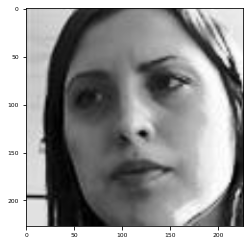

In [246]:
# tylko sprawdzmy czy wszystko poszło ok.
img = train_images_processed[1,:,:,:].copy()
img = (img -np.min(img)) * 255 / (np.max(img) - np.min(img))
plt.imshow(img.astype(np.uint8))
train_images_processed.dtype

In [247]:
# uczenie z augmentacją
history = new_model_transfer.fit(datagen.flow(train_images_processed, train_labels, batch_size=16), epochs=30, validation_data=validation_ds,
          validation_freq=1)

# uczenie bez augmentacji
#new_model_transfer.fit(train_ds, epochs=40, validation_data=validation_ds,
#          validation_freq=1)

Epoch 1/30
16/16 [==============================] - 4s 224ms/step - loss: 3.3945 - accuracy: 0.1145 - val_loss: 2.5869 - val_accuracy: 0.2188
Epoch 2/30
16/16 [==============================] - 3s 189ms/step - loss: 2.6006 - accuracy: 0.2305 - val_loss: 2.1464 - val_accuracy: 0.3594
Epoch 3/30
16/16 [==============================] - 3s 187ms/step - loss: 2.3359 - accuracy: 0.3032 - val_loss: 1.7533 - val_accuracy: 0.4844
Epoch 4/30
16/16 [==============================] - 3s 183ms/step - loss: 2.0365 - accuracy: 0.3774 - val_loss: 1.5099 - val_accuracy: 0.4688
Epoch 5/30
16/16 [==============================] - 3s 185ms/step - loss: 1.8750 - accuracy: 0.4169 - val_loss: 1.1894 - val_accuracy: 0.6875
Epoch 6/30
16/16 [==============================] - 3s 187ms/step - loss: 1.4434 - accuracy: 0.5964 - val_loss: 1.1107 - val_accuracy: 0.6094
Epoch 7/30
16/16 [==============================] - 3s 187ms/step - loss: 1.4278 - accuracy: 0.5643 - val_loss: 0.9637 - val_accuracy: 0.7344
Epoch 

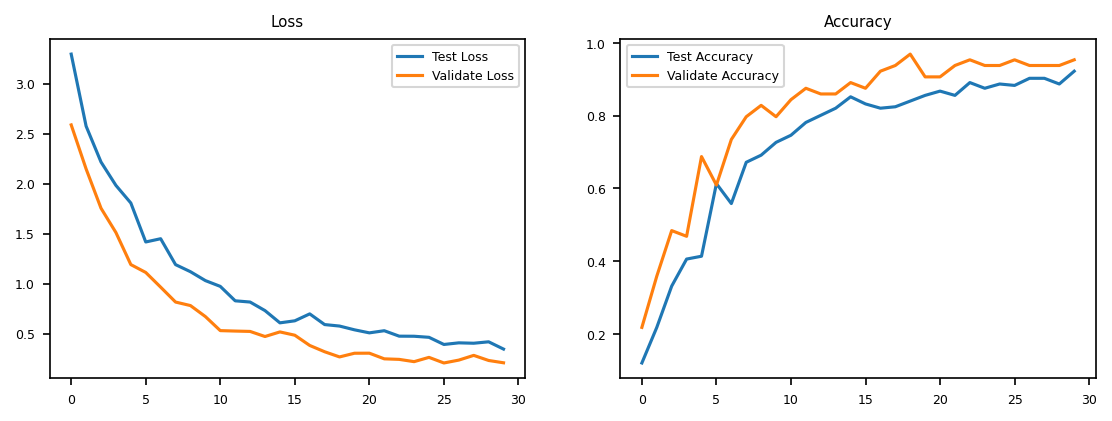

In [248]:
f,ax = plt.subplots(1,2, dpi=150, figsize=(9,3))
ax[0].plot(history.history['loss'], label='Test Loss')
ax[0].plot(history.history['val_loss'], label='Validate Loss')
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='Test Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validate Accuracy')
ax[1].set_title("Accuracy")
ax[1].legend()


In [249]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Sprawdzamy wynik na danych testowych.

In [250]:
new_model_transfer.evaluate(test_ds)

2/2 [==============================] - 0s 85ms/step - loss: 0.2845 - accuracy: 0.9375


[0.28452739119529724, 0.9375]

In [251]:
new_model.predict(test_ds)

array([[0.3325872 , 0.        , 0.        , ..., 0.        , 0.        ,
        1.1882206 ],
       [0.13512926, 0.        , 0.10078698, ..., 0.        , 0.        ,
        0.06306849],
       [4.326791  , 0.        , 0.        , ..., 1.5932074 , 0.03175312,
        0.        ],
       ...,
       [0.90134037, 0.        , 0.        , ..., 2.3642395 , 1.3823129 ,
        0.        ],
       [0.34443352, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.2530993 , 0.        , 0.05828453, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

Wykorzystując metodę głosowania większościowego wybieramy klasę. Technicznie określamy numer kolumny w każdym wierszu zwracanym przez sieć `pred` o wartości nawiększego prawdopodobieństwa. Pamiętamy, że keras obliczy wartości dla całego batcha o zawierającego 32 obrazy, zwróci zatem macierz o rozmiarach: 32 wierszy na 20 kolumn.

In [252]:
def debug(msg):
    pass
    # print(msg) # odkomentuj jeżeli chcesz obejrzeć wartości

images = []
y_true = []
y_pred = []
for batch in test_ds:
    pred = new_model_transfer.predict(batch[0])
    for idx, (prawdopodobienstwo, oczekiwane) in enumerate(zip(pred, batch[1])):
        debug(f"oczekiwana: {oczekiwane} obliczona : {np.argmax(prawdopodobienstwo)}")

        images.append(batch[0][idx,:,:,:]) # zapamietaj skojarzony obrazek
        y_true.append(oczekiwane)          # zapamiętaj wartosć rzeczywistą
        y_pred.append(np.argmax(prawdopodobienstwo)) # zapamiętaj pozycję z największym prawdopodobieństwem

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [253]:
confusion_matrix(y_pred, y_true)

array([[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [254]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       0.50      0.33      0.40         3
           7       1.00      1.00      1.00         5
           8       1.00      0.25      0.40         4
           9       1.00      1.00      1.00         4
          10       0.57      1.00      0.73         4
          11       0.67      1.00      0.80         2
          13       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         6
          16       1.00      0.67      0.80         3
          17       1.00      1.00      1.00         1
          18       1.00      1.00      1.00         5
          19       1.00      1.00      1.00         4

    accuracy              

Znajdź wszystkie przypadki błędnie sklasyfikowane, aby móc je obejrzeć.

In [255]:
blednie_sklasyfikowane = np.where( y_true != y_pred )
blednie_sklasyfikowane

(array([ 0,  2, 14, 24, 29, 49]),)

In [256]:
@interact(idx=blednie_sklasyfikowane[0].tolist())
def show_image(idx):
    # skalujemy znormalizowane dane do palety kolorów RGB(255,255,255) 
    img = (images[idx].numpy() -np.min(images[idx].numpy())) * 255 / (np.max(images[idx].numpy()) - np.min(images[idx].numpy()))

    plt.figure(dpi=150)
    plt.imshow(img.astype(np.uint8))
    plt.title(f"Oczekiwane: {y_true[idx]}, Obliczone: {y_pred[idx]}")

interactive(children=(Dropdown(description='idx', options=(0, 2, 14, 24, 29, 49), value=0), Output()), _dom_cl…

Przekonwertujemy wektor klas do kodowania one-hot-encoding (kazda kolumna będzie osobną klasą wartość 1 oznacza przynależnośc do danej klasy, wartość 0 - nie). W każdym wierszu macierzy będzie tylko jedna wartość niezerowa.

In [257]:
idx = np.where( y_true == 0 )
y_true_hot_one = np.zeros( (y_true.shape[0], 20) )
for idx, c in enumerate(y_true):
    y_true_hot_one[idx, c] = 1.0
#y_true_hot_one

Obliczmy wartości predykcji za pomocą nauczonego modelu. Używamy listy obrazków, które pobraliśmy dla dwóch batchy? (64 obrazki) - część się powtarza. 

In [258]:
y_pred_keras = new_model_transfer.predict((np.array(images)))

Analizujemy wyniki bardzo szeczegółowo. Chcemy pokazać oryginalną klasę, klasę wyznaczoną przez sieć (numer kolumny z maksymalnym prawdopodobieństwem obliczonym przez ostatnią warstwę sieci - Softmax), wartość maksymalnego prawdopodobieństwa dla danego przypadku oraz wartość drugiego co do wielkości prawdopodobieństwa. Porównanie dwóch ostatnich wielkości pokazuje nam stopień pewności klasyfikacji danego przypadku.

In [259]:
print(f"Rozmiar macierzy zawierającego zawierającej prawdopodobieństwa przynależności do danej klasy: {y_pred_keras.shape}")
print(f"{'-'*110}")

res = []
print("Klasy oczekiwane, oraz prawdopodobieństwa obliczone dla maksymalnej klasy w formie listy.")
for y_t, y_p in zip(y_true, y_pred_keras):
    y_p_sorted = np.sort(y_p)
    res.append( (y_t, np.argmax(y_p), y_p_sorted[-1], y_p_sorted[-2]) )
    #print(f"Klasa rzeczywista: {y_t:4}, Klasa obliczona (nr maksymalnego P_max): {np.argmax(y_p)}, P_max: {y_p_sorted[-1]:.2f}, P_max_2: {y_p_sorted[-2]:.2f}")

# używamy Pandas i Dataframe tylko po to aby ładnie wyświetlić wyniki    
df = pd.DataFrame(data=res, columns=["Klasa rzeczywista", "Klasa obliczona (nr. max. P_max)", "P_max", "P_max_2"])
pd.set_option('display.max_rows', 100)
df = df.sort_values("Klasa rzeczywista")
display(df)

Rozmiar macierzy zawierającego zawierającej prawdopodobieństwa przynależności do danej klasy: (64, 20)
--------------------------------------------------------------------------------------------------------------
Klasy oczekiwane, oraz prawdopodobieństwa obliczone dla maksymalnej klasy w formie listy.


,Klasa rzeczywista,Klasa obliczona (nr. max. P_max),P_max,P_max_2
31,1,1,0.968469,0.012425
58,1,1,0.983609,0.005626
45,1,1,0.988946,0.001931
41,1,1,0.747690,0.058473
32,1,1,0.876091,0.036032
25,1,1,0.987343,0.007939
21,1,1,0.972139,0.008626
63,1,1,0.901762,0.021326
36,2,2,0.998526,0.000302
59,2,2,0.805252,0.170037


Narysujemy krzywą ROC dla każdej klasy osobno oraz w legendzie napiszemy wartość powierzchni pod krzywą: AUC (ang. area under curve). Wykresy będą dość 'kańciaste' ponieważ nasz zbiór testowy jest stosunkowo mały.

AUC dla klasy: 2: 1.0
AUC dla klasy: 3: 1.0
AUC dla klasy: 4: 1.0
AUC dla klasy: 6: 1.0
AUC dla klasy: 7: 0.9758064516129032
AUC dla klasy: 8: 1.0
AUC dla klasy: 9: 1.0
AUC dla klasy: 10: 1.0
AUC dla klasy: 11: 1.0
AUC dla klasy: 12: 1.0
AUC dla klasy: 14: 1.0
AUC dla klasy: 15: 1.0
AUC dla klasy: 16: 1.0
AUC dla klasy: 17: 1.0
AUC dla klasy: 18: 1.0
AUC dla klasy: 19: 1.0
AUC dla klasy: 20: 1.0


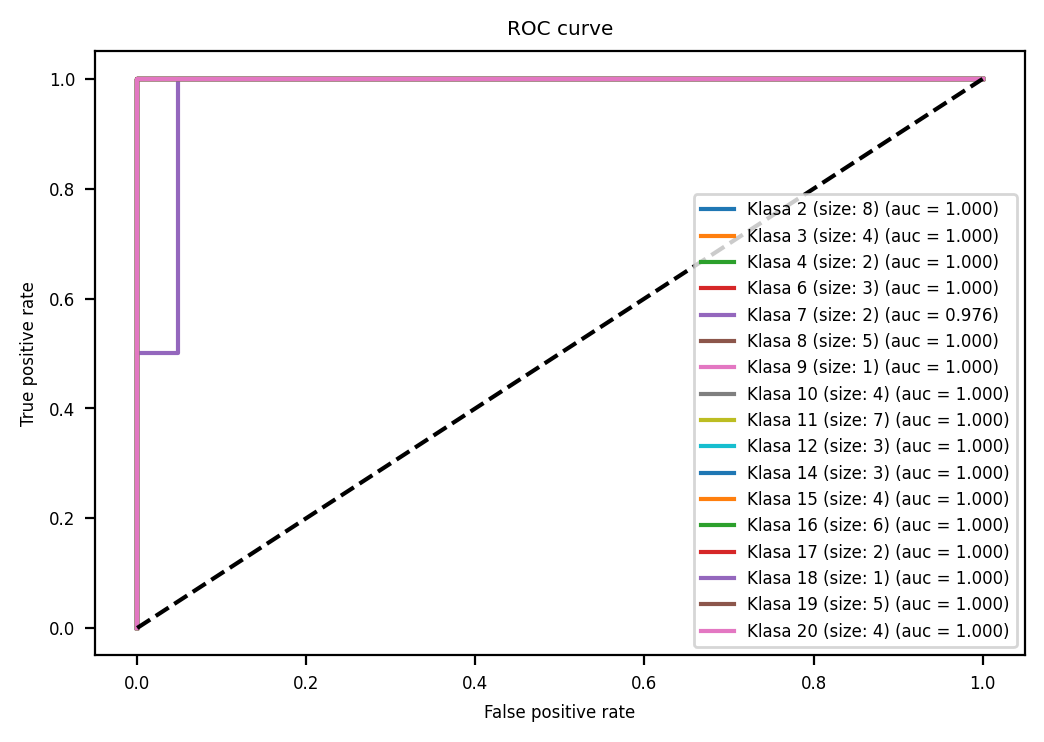

In [260]:
plt.figure(1, dpi=200)
for i in range(20):
    if (np.sum(y_true_hot_one[:,i]) > 0):
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_hot_one[:,i], y_pred_keras[:,i])
        auc_keras = auc(fpr_keras, tpr_keras)
        print(f"AUC dla klasy: {i+1}: {auc_keras}")

        plt.plot(fpr_keras, tpr_keras, label=f'Klasa {i+1} (size: {np.sum(y_true_hot_one[:,i]).astype(np.uint)}) (auc = {auc_keras:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


Teraz narysujemy zbiorczy ROC dla wszystkich klas. Wykonamy to w ten sposób, że weźmiemy macierze: przynależności do klas (one-hot-encoded) oczekiwane -zera i jedynki oraz prawdopodobieństwa przynależności do danej klasy obliczone za pomocą sieci. Następnie przekształcimy obie macierze do postaci wektorowej (wierzami, za pomocą funkcji `ravel()`). 

Gotowe wektory:

* `y_true_hot_one.ravel()` - zawierający wartości `0` i `1`
* `y_pred_keras.ravel()` - zawierający prawdopodobieństwa $p_i \in <0,1>$

przekażemy do funkcji generującej krzywą ROC.

AUC zbiorczy: 0.9972116570723684


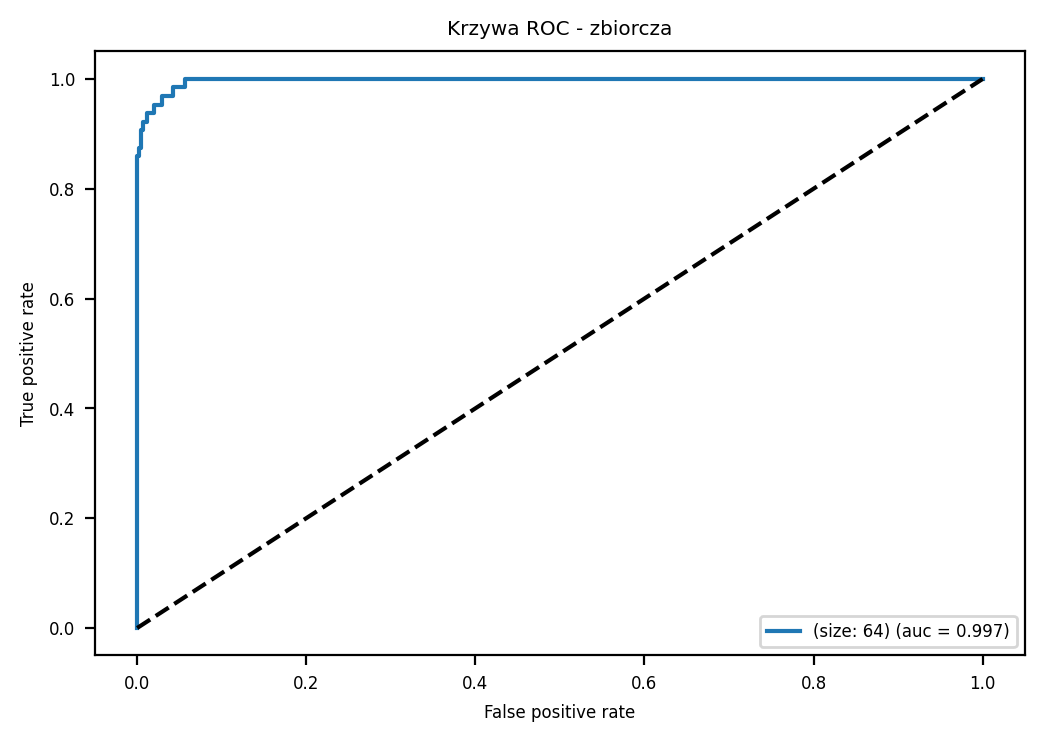

In [261]:
# ROC zbiorczy

y_pred_keras = new_model_transfer.predict((np.array(images)))
y_pred_keras.shape

plt.rc('font', size=6) 
plt.figure(1, dpi=200)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true_hot_one.ravel(), y_pred_keras.ravel())
auc_keras = auc(fpr_keras, tpr_keras)
print(f"AUC zbiorczy: {auc_keras}")

plt.plot(fpr_keras, tpr_keras, label=f'(size: {len(y_true)}) (auc = {auc_keras:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Krzywa ROC - zbiorcza')
plt.legend(loc='best')
plt.show()